<a href="https://colab.research.google.com/github/aprajeeta10/python-projects/blob/main/Calculate_Value_at_Risk_(VaR)_Using_the_Monte_Carlo_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SOURCE CODE GUIDANCE/REFERENCE: https://www.youtube.com/watch?v=X8aNFXJEENs&t=323s

##Importing Libraries


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

##Setting Time Range and Ticker List


In this section, we set the time range for our historical data to 15 years and create a list of stock tickers for our portfolio.



In [ ]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

##Downloading Adjusted Close Prices

Next, we download the daily adjusted close prices for each stock ticker using the yfinance library and store the data in a DataFrame.

In [ ]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2008-08-04   93.331268  48.957008   88.139999   38.895512   47.327236
2008-08-05   95.847649  48.756401   86.080002   40.208649   48.539001
2008-08-06   96.273270  48.691727   86.639999   40.821453   48.599228
2008-08-07   94.839615  49.002327   86.089996   40.506310   47.906757
2008-08-08   96.601852  48.982914   84.430000   41.425507   48.922859
...                ...        ...         ...         ...         ...
2023-07-24  454.200012  72.500000  181.399994  376.230011  226.320007
2023-07-25  455.440002  7

##Calculating Daily Log Returns


We calculate the daily log returns for each stock in our portfolio and drop any missing values.



In [ ]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2008-08-05  0.026605 -0.004106 -0.023649  0.033203  0.025282
2008-08-06  0.004431 -0.001327  0.006484  0.015126  0.001240
2008-08-07 -0.015004  0.006359 -0.006368 -0.007750 -0.014351
2008-08-08  0.018411 -0.000396 -0.019470  0.022439  0.020988
2008-08-11  0.010305 -0.004236 -0.039870  0.009046  0.009950
...              ...       ...       ...       ...       ...
2023-07-24  0.004457 -0.001654 -0.004291  0.001596  0.003541
2023-07-25  0.002726 -0.001104  0.005552  0.006755  0.002515
2023-07-26  0.000154  0.003309  0.004867 -0.003332  0.000749
2023-07-27 -0.006652 -0.008570 -0.015837 -0.002387 -0.007737
2023-07-28  0.009743  0.003464  0.007950  0.018051  0.010376

[3771 rows x 5 columns]


##Defining Functions to Calculate Portfolio Expected Return and Standard Deviation


We define two functions, expected_return() and standard_deviation(), which will be used to calculate the expected return and standard deviation of our portfolio, respectively.

In [ ]:
### Create a function that will be used to calculate portfolio expected return
###We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

##Creating a Covariance Matrix


We create a covariance matrix for all the securities in our portfolio using the daily log returns.



In [ ]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.678617e-04  3.732453e-08  0.000007  1.718036e-04  1.685512e-04
BND  3.732453e-08  1.069062e-05  0.000009 -2.561426e-07 -3.029075e-08
GLD  6.742162e-06  8.662907e-06  0.000119  5.677838e-06  7.944638e-06
QQQ  1.718036e-04 -2.561426e-07  0.000006  2.048117e-04  1.738739e-04
VTI  1.685512e-04 -3.029075e-08  0.000008  1.738739e-04  1.713505e-04


##Calculating Portfolio Expected Return and Standard Deviation


We create an equally weighted portfolio and calculate the portfolio’s expected return and standard deviation using the functions we defined earlier.



In [ ]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

##Defining Functions for Monte Carlo Simulation


We define two functions: random_z_score() and scenario_gain_loss(). The first function generates a random Z-score based on a normal distribution, and the second function calculates the gain or loss for a given scenario.

In [ ]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

##Running Monte Carlo Simulation


We run 10,000 Monte Carlo simulations, calculating the scenario gain/loss for each simulation and storing the results in a list.

In [ ]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

##Calculating Value at Risk (VaR)


We specify a confidence interval of 99% and calculate Value at Risk (VaR) using the results of our simulations.

In [ ]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

83736.12497249298


##Plotting the Results


Finally, we create a histogram to visualize the distribution of portfolio gain/loss over the specified number of days. We also add a vertical dashed line to indicate the VaR at our chosen confidence level.

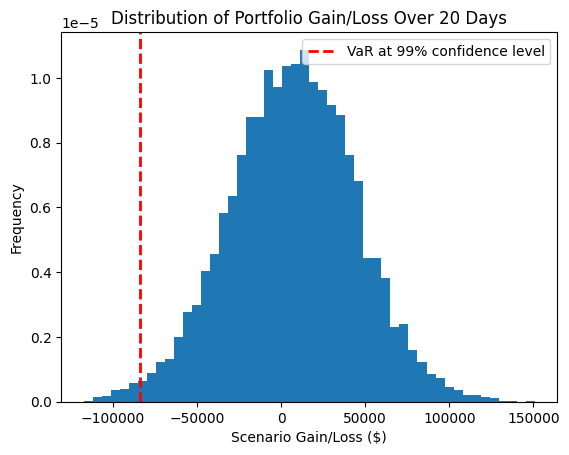

In [ ]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()